<a href="https://colab.research.google.com/github/Printz-Lab/segmenteverygrain/blob/main/Perovskite_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Every Grain

A SAM-based model for instance segmentation of images of grains

## Install and import packages

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!{sys.executable} -m pip install segmenteverygrain
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-d_28l3rk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-d_28l3rk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=aef3b5a7d267c653161f8373d8a38ec07999cfcb3f982e23f57d4b00b7b91080
  Stored in directory: /tmp/pip-ephem-wheel-cache-p82q6sl3/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.1 MB/s eta 0:00:00
--2023-08-29 01:26:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving 

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from tqdm import trange

## Download Unet model weights and create Unet model

(there must be an easier way of doing this...)

In [ ]:
mkdir checkpoints

In [ ]:
cd checkpoints

/content/checkpoints


In [ ]:
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/checkpoint"
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/seg_model.data-00000-of-00001"
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/seg_model.index"

--2023-08-29 01:27:18--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/checkpoint
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75 [text/plain]
Saving to: ‘checkpoint’

checkpoint          100%[===================>]      75  --.-KB/s    in 0s      

2023-08-29 01:27:19 (2.02 MB/s) - ‘checkpoint’ saved [75/75]

--2023-08-29 01:27:19--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/seg_model.data-00000-of-00001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, await

In [ ]:
cd ..

/content


In [ ]:
import tensorflow as tf
model = seg.Unet()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('./checkpoints/seg_model')

## Set up interactive figure backend in Colab

In [ ]:
# this is needed to make figures in Colab interactive
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


In [ ]:
%matplotlib ipympl

## Run segmentation

Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pxiels, it is unlikely to be detected.

The segmentation can take a few minutes even for medium-sized images, so do not start with large images (downsample them if necessary).

In [ ]:
# get example image
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/images/A003_20201229_103823_image.png"

--2023-08-29 01:27:45--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/images/A003_20201229_103823_image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2342693 (2.2M) [image/png]
Saving to: ‘A003_20201229_103823_image.png’

A003_20201229_10382 100%[===================>]   2.23M  --.-KB/s    in 0.02s   

2023-08-29 01:27:47 (124 MB/s) - ‘A003_20201229_103823_image.png’ saved [2342693/2342693]



In [ ]:
fname = '5avacl.jpeg'

big_im = np.array(load_img(fname))
big_im_pred = seg.predict_big_image(big_im, model, I=256)
# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=10.0)
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels, min_area=100.0)

100%|██████████| 401/401 [00:35<00:00, 11.44it/s]
400it [00:37, 10.66it/s]
 47%|████▋     | 45/96 [00:03<00:04, 12.68it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
100%|██████████| 130/130 [00:01<00:00, 93.41it/s] 


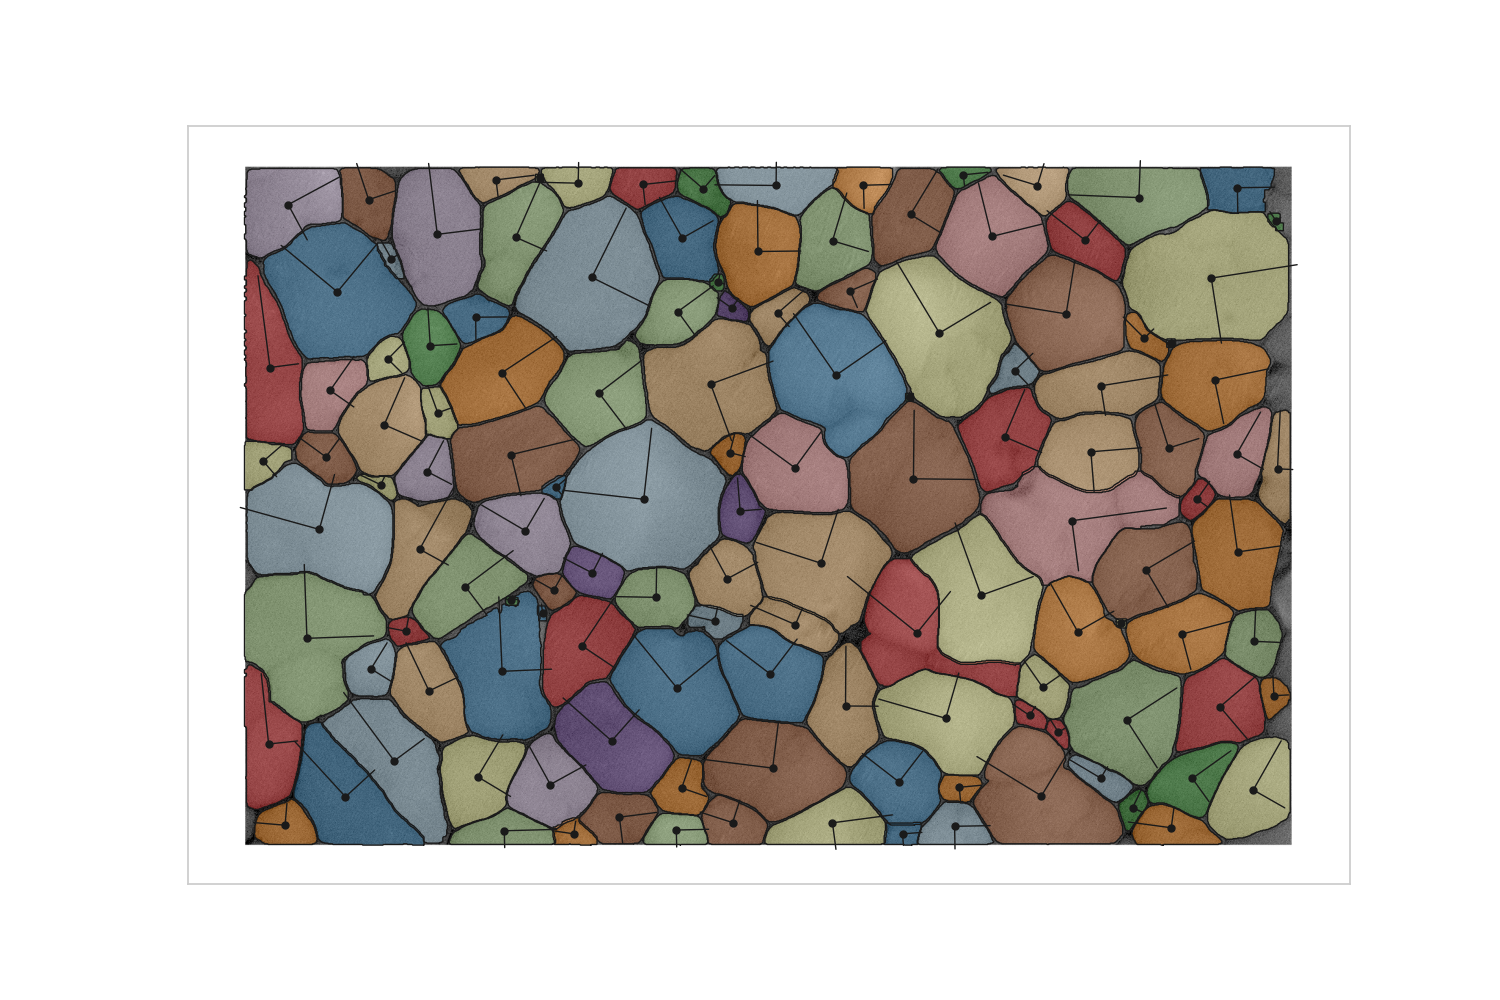

In [ ]:
# plot results again if necessary
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(big_im)
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)

## Delete or merge grains in segmentation result
* click on the grain that you want to remove and press the 'x' key
* click on two grains that you want to merge and press the 'm' key (they have to be the last two grains you clicked on)

In [ ]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event',
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event',
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run this cell if you do not want to delete / merge existing grains anymore; it is a good idea to do this before moving on to the next step.

In [ ]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

## Add new grains using the Segment Anything Model

* click on unsegmented grain that you want to add
* press the 'x' key if you want to delete the last grain you added
* press the 'm' key if you want to merge the last two grains that you added
* right click outside the grain (but inside the most recent mask) if you want to restrict the grain to a smaller mask - this adds a background prompt

In [ ]:
predictor = SamPredictor(sam)
predictor.set_image(big_im) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, big_im, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

After you are done with the deletion / addition of grain masks, run this cell to generate an updated set of grains:

100%|██████████| 130/130 [00:01<00:00, 101.18it/s]


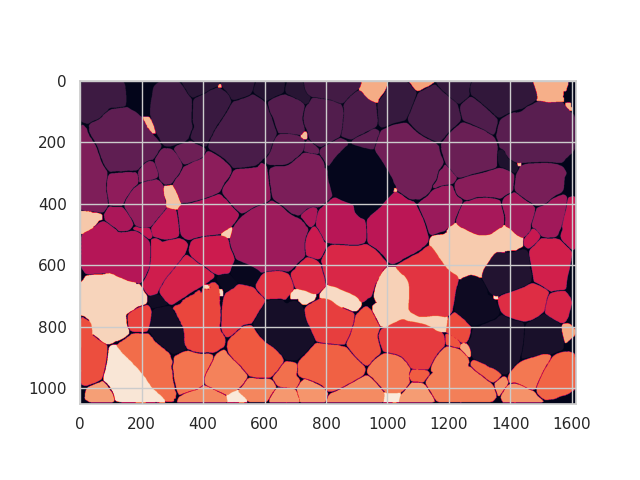

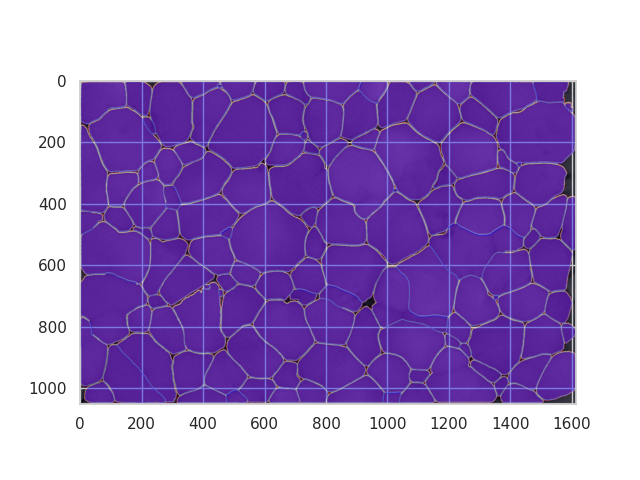

In [ ]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

Display grain statistics and generate histograms

label   area   centroid-0   centroid-1  major_axis_length  \
0        1   7543    52.642980   191.125282         117.376497   
1        2  33409   323.526714   912.130803         230.983867   
2        3   5314   628.623636   536.153368         100.415397   
3        4   2499   655.066026   476.718687          64.049975   
4        5  16556   719.140070  1285.095977         169.682236   
..     ...    ...          ...          ...                ...   
125    126    252   689.920635   459.492063          26.382121   
126    127    171   706.198830  1352.520468          18.533685   
127    128  19965   973.999249   155.329477         231.011030   
128    129   1868  1031.132762   507.557816          66.493618   
129    130   1566  1031.172414  1014.798851          59.915830   

     minor_axis_length  orientation   perimeter  max_intensity-0  \
0            84.384097     0.320894  346.308658            144.0   
1           187.546352     0.604409  727.193001            191.0   
2            68.359810     1.091882  287.078210            152.0   
3            50.794841     1.059644  193.622366            142.0   
4           127.966093     0.515042  511.629509            174.0   
..                 ...          ...         ...              ...   
125          12.677038     0.144925   65.899495            127.0   
126          12.480773     1.282259   52.313708            136.0   
127         122.287106     0.742361  648.783838            142.0   
128          39.035397     1.424963  193.160426            148.0   
129          35.632431    -1.493776  175.870058            144.0   

     max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0              144.0            144.0         86.605462         86.605462   
1              191.0            191.0        122.759975        122.759975   
2              152.0            152.0         99.676703         99.676703   
3              142.0            142.0         82.772709         82.772709   
4              174.0            174.0        112.017516        112.017516   
..               ...              ...               ...               ...   
125            127.0            127.0         87.789683         87.789683   
126            136.0            136.0         80.678363         80.678363   
127            142.0            142.0         86.226897         86.226897   
128            148.0            148.0         95.139722         95.139722   
129            144.0            144.0         88.659004         88.659004   

     mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0           86.605462              0.0              0.0              0.0  
1          122.759975              0.0              0.0              0.0  
2           99.676703              1.0              1.0              1.0  
3           82.772709              0.0              0.0              0.0  
4          112.017516              3.0              3.0              3.0  
..                ...              ...              ...              ...  
125         87.789683             48.0             48.0             48.0  
126         80.678363              4.0              4.0              4.0  
127         86.226897              0.0              0.0              0.0  
128         95.139722              0.0              0.0              0.0  
129         88.659004              0.0              0.0              0.0  

[130 rows x 17 columns]

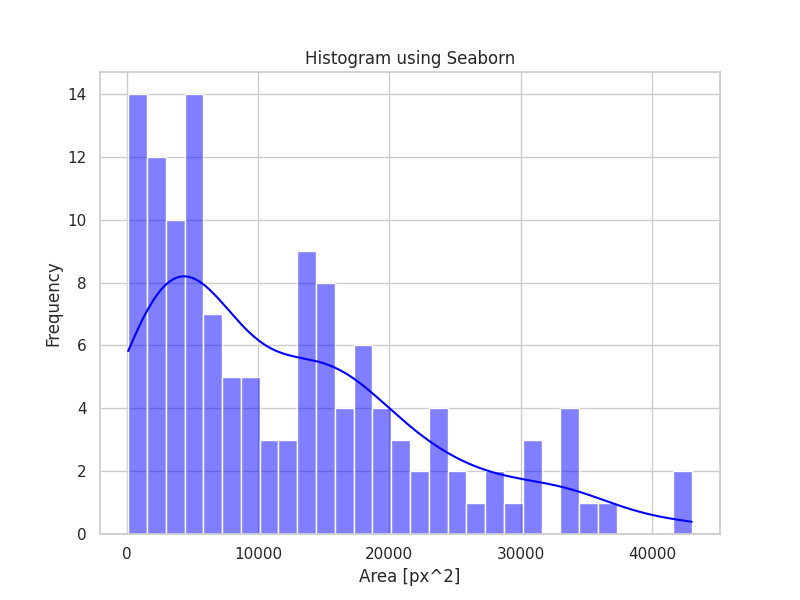

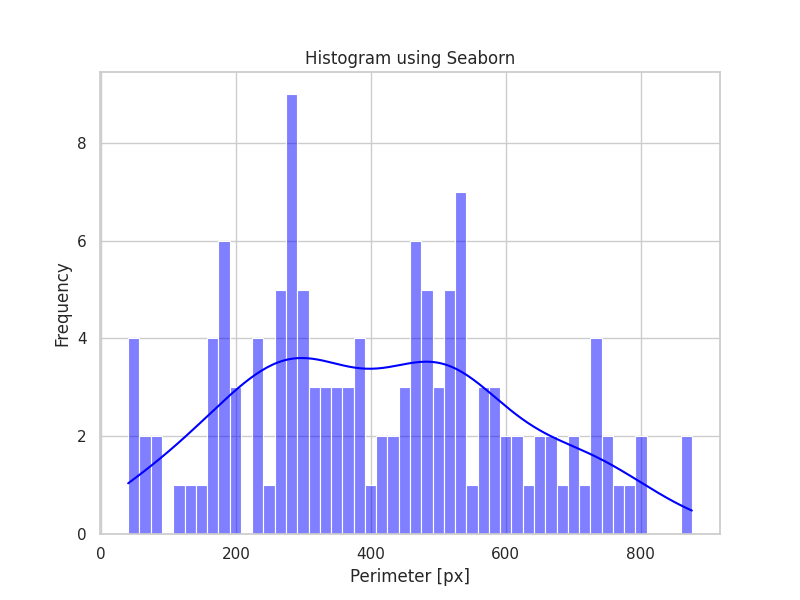

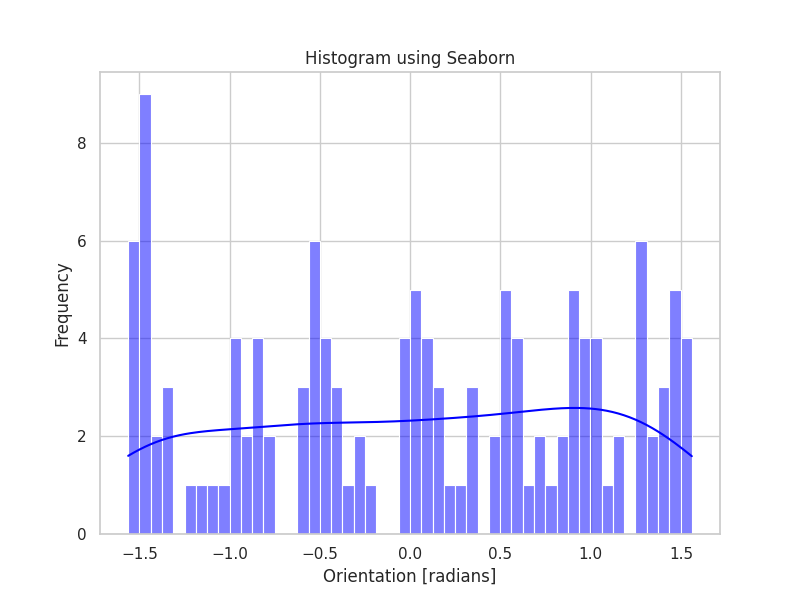

In [ ]:
display(grain_data)

import seaborn as sns

# Create a histogram using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(grain_data['area'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel('Area [px^2]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(grain_data['perimeter'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Perimeter [px]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(grain_data['orientation'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Orientation [radians]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

## Save mask and grain labels to PNG files

In [ ]:
dirname = '/content/'
# write grayscale mask to PNG file
print(fname.split('.')[0])
cv2.imwrite(dirname + fname.split('.')[0] + '_mask.png', mask_all)
# Define a colormap using matplotlib
num_classes = len(all_grains)
cmap = plt.get_cmap('viridis', num_classes)
# Map each class label to a unique color using the colormap
vis_mask = cmap(labels.astype(np.uint16))[:,:,:3] * 255
vis_mask = vis_mask.astype(np.uint8)
# Save the mask as a PNG file
cv2.imwrite(dirname + fname.split('.')[0] + '_labels.png', vis_mask)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('.')[0] + '_image.png', cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB))

5avacl


True